In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups_vectorized
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import EarlyStopping  # Ensure this line is included
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def create_fnn(kernel_initializer=None, input_shape=None, num_classes=None):
    model = Sequential()
    model.add(Dense(64, activation='relu', kernel_initializer=kernel_initializer, input_shape=input_shape))
    model.add(Dense(32, activation='relu', kernel_initializer=kernel_initializer))
    model.add(Dense(num_classes, activation='softmax', kernel_initializer=kernel_initializer))
    return model

In [3]:
datasets = {
    'MNIST': mnist.load_data(),
    'CIFAR-10': cifar10.load_data(),
    '20 Newsgroups': fetch_20newsgroups_vectorized(subset='all', return_X_y=True)
}

In [4]:
initializers_dict = {
    'Zero': 'zeros',
    'Random': 'random_normal',
    'Xavier': 'glorot_normal',
    'He': 'he_normal',
    'LeCun': 'lecun_normal',
    'Orthogonal': 'orthogonal',
    'Sparse': tf.keras.initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
}

In [5]:
def compile_and_train(model, initializer_name, x_train, y_train, x_test, y_test):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    history = model.fit(x_train, y_train, 
                        epochs=50,  # Increased the number of epochs to allow early stopping to take effect
                        batch_size=64, 
                        validation_data=(x_test, y_test),
                        callbacks=[early_stopping])
    
    test_loss, test_acc = model.evaluate(x_test, y_test)
    
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='macro')
    
    return {
        'history': history.history,
        'test_acc': test_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [6]:
results = {}

for dataset_name, dataset in datasets.items():
    if dataset_name == '20 Newsgroups':
        x, y = dataset
        x_train, x_test = x[:11314], x[11314:]
        y_train, y_test = to_categorical(y[:11314], 20), to_categorical(y[11314:], 20)
    else:
        (x_train, y_train), (x_test, y_test) = dataset
        x_train = x_train.reshape(x_train.shape[0], -1)
        x_test = x_test.reshape(x_test.shape[0], -1)
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)
    
    dataset_results = {}
    
    # Train normal FNN with default initializer
    print(f'--- Training normal FNN on {dataset_name} with default initialization ---')
    fnn_model = create_fnn(input_shape=(x_train.shape[1],), num_classes=y_train.shape[1])
    dataset_results['Default'] = compile_and_train(fnn_model, 'Default', x_train, y_train, x_test, y_test)
    
    # Train FNNs with different kernel initializations
    for initializer_name, initializer in initializers_dict.items():
        print(f'--- Training FNN on {dataset_name} with {initializer_name} initialization ---')
        fnn_model = create_fnn(initializer, (x_train.shape[1],), y_train.shape[1])
        dataset_results[initializer_name] = compile_and_train(fnn_model, initializer_name, x_train, y_train, x_test, y_test)
    
    results[dataset_name] = dataset_results

--- Training normal FNN on MNIST with default initialization ---


Epoch 1/50


938/938 [==============================] - 3s 2ms/step - loss: 2.1121 - accuracy: 0.5791 - val_loss: 0.8271 - val_accuracy: 0.7245
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 0.7081 - accuracy: 0.7705 - val_loss: 0.5579 - val_accuracy: 0.8315
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.4901 - accuracy: 0.8516 - val_loss: 0.4543 - val_accuracy: 0.8878
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.3459 - accuracy: 0.9086 - val_loss: 0.2950 - val_accuracy: 0.9254
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.2261 - accuracy: 0.9384 - val_loss: 0.2023 - val_accuracy: 0.9453
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.1745 - accuracy: 0.9512 - val_loss: 0.1856 - val_accuracy: 0.9515
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.146

C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


938/938 [==============================] - 3s 3ms/step - loss: 0.3688 - accuracy: 0.8965 - val_loss: 0.1983 - val_accuracy: 0.9362
Epoch 2/50
938/938 [==============================] - 2s 3ms/step - loss: 0.1512 - accuracy: 0.9552 - val_loss: 0.1289 - val_accuracy: 0.9610
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.1210 - accuracy: 0.9632 - val_loss: 0.1387 - val_accuracy: 0.9614
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.1010 - accuracy: 0.9695 - val_loss: 0.1217 - val_accuracy: 0.9644
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.0918 - accuracy: 0.9717 - val_loss: 0.1094 - val_accuracy: 0.9690
Epoch 6/50
938/938 [==============================] - 2s 2ms/step - loss: 0.0821 - accuracy: 0.9747 - val_loss: 0.1460 - val_accuracy: 0.9645
Epoch 7/50
938/938 [==============================] - 2s 2ms/step - loss: 0.0788 - accuracy: 0.9759 - val_loss: 0.1366 - val_accuracy: 0.9660
Epoch 8/50
313/31

C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


938/938 [==============================] - 3s 2ms/step - loss: 0.2603 - accuracy: 0.9210 - val_loss: 0.1606 - val_accuracy: 0.9513
Epoch 2/50
938/938 [==============================] - 2s 2ms/step - loss: 0.1370 - accuracy: 0.9593 - val_loss: 0.1620 - val_accuracy: 0.9515
Epoch 3/50
938/938 [==============================] - 2s 2ms/step - loss: 0.1081 - accuracy: 0.9668 - val_loss: 0.1334 - val_accuracy: 0.9632
Epoch 4/50
938/938 [==============================] - 2s 2ms/step - loss: 0.0939 - accuracy: 0.9714 - val_loss: 0.1374 - val_accuracy: 0.9609
Epoch 5/50
938/938 [==============================] - 2s 2ms/step - loss: 0.0836 - accuracy: 0.9750 - val_loss: 0.1475 - val_accuracy: 0.9628
Epoch 6/50
313/313 [==============================] - 1s 2ms/step
--- Training normal FNN on CIFAR-10 with default initialization ---
Epoch 1/50
782/782 [==============================] - 3s 4ms/step - loss: 8.8093 - accuracy: 0.1585 - val_loss: 2.9334 - val_accuracy: 0.1908
Epoch 2/50
782/782 [=====

C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


782/782 [==============================] - 3s 4ms/step - loss: 2.3027 - accuracy: 0.0947 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 3s 4ms/step - loss: 2.3027 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 2.3027 - accuracy: 0.0991 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 3s 4ms/step - loss: 2.3027 - accuracy: 0.0974 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/50
782/782 [==============================] - 3s 4ms/step - loss: 2.3027 - accuracy: 0.0972 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/50
782/782 [==============================] - 3s 3ms/step - loss: 2.3027 - accuracy: 0.0990 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/50
313/313 [==============================] - 1s 2ms/step
--- Training FNN on CIFAR-10 with Random initialization ---
Epoch 1/50


C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


782/782 [==============================] - 3s 4ms/step - loss: 2.4492 - accuracy: 0.2059 - val_loss: 2.0200 - val_accuracy: 0.2212
Epoch 2/50
782/782 [==============================] - 2s 3ms/step - loss: 1.9805 - accuracy: 0.2490 - val_loss: 1.9649 - val_accuracy: 0.2661
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 1.9470 - accuracy: 0.2716 - val_loss: 1.8962 - val_accuracy: 0.2869
Epoch 4/50
782/782 [==============================] - 2s 3ms/step - loss: 1.9242 - accuracy: 0.2798 - val_loss: 1.8978 - val_accuracy: 0.2818
Epoch 5/50
782/782 [==============================] - 2s 3ms/step - loss: 1.9126 - accuracy: 0.2906 - val_loss: 1.8872 - val_accuracy: 0.2898
Epoch 6/50
782/782 [==============================] - 2s 3ms/step - loss: 1.8942 - accuracy: 0.2962 - val_loss: 1.8666 - val_accuracy: 0.3151
Epoch 7/50
782/782 [==============================] - 2s 3ms/step - loss: 1.8898 - accuracy: 0.3020 - val_loss: 1.8929 - val_accuracy: 0.3042
Epoch 8/50
782/78

C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


782/782 [==============================] - 3s 3ms/step - loss: 7.3032 - accuracy: 0.0999 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 3s 3ms/step - loss: 2.3032 - accuracy: 0.0977 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 2.3028 - accuracy: 0.0980 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/50
313/313 [==============================] - 0s 1ms/step
--- Training FNN on CIFAR-10 with LeCun initialization ---
Epoch 1/50


C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


782/782 [==============================] - 3s 3ms/step - loss: 7.4026 - accuracy: 0.1090 - val_loss: 2.3033 - val_accuracy: 0.1001
Epoch 2/50
782/782 [==============================] - 2s 3ms/step - loss: 2.3028 - accuracy: 0.0969 - val_loss: 2.3033 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 2.3023 - accuracy: 0.1007 - val_loss: 2.3035 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 3s 3ms/step - loss: 2.3027 - accuracy: 0.0979 - val_loss: 2.3034 - val_accuracy: 0.0998
Epoch 5/50
313/313 [==============================] - 1s 1ms/step
--- Training FNN on CIFAR-10 with Orthogonal initialization ---
Epoch 1/50


C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


782/782 [==============================] - 3s 4ms/step - loss: 12.5982 - accuracy: 0.1597 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 2/50
782/782 [==============================] - 3s 3ms/step - loss: 2.3033 - accuracy: 0.1000 - val_loss: 2.3025 - val_accuracy: 0.1000
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 2.3028 - accuracy: 0.0985 - val_loss: 2.3024 - val_accuracy: 0.1000
Epoch 4/50
782/782 [==============================] - 3s 4ms/step - loss: 2.3027 - accuracy: 0.0976 - val_loss: 2.3025 - val_accuracy: 0.1003
Epoch 5/50
782/782 [==============================] - 2s 3ms/step - loss: 2.3028 - accuracy: 0.0993 - val_loss: 2.3024 - val_accuracy: 0.1003
Epoch 6/50
313/313 [==============================] - 1s 1ms/step
--- Training FNN on CIFAR-10 with Sparse initialization ---


C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/50
782/782 [==============================] - 3s 3ms/step - loss: 2.2088 - accuracy: 0.1539 - val_loss: 2.1347 - val_accuracy: 0.1725
Epoch 2/50
782/782 [==============================] - 2s 3ms/step - loss: 2.0952 - accuracy: 0.1776 - val_loss: 2.0637 - val_accuracy: 0.1869
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 2.0796 - accuracy: 0.1824 - val_loss: 2.1755 - val_accuracy: 0.1713
Epoch 4/50
782/782 [==============================] - 2s 3ms/step - loss: 2.0870 - accuracy: 0.1797 - val_loss: 2.0711 - val_accuracy: 0.1894
Epoch 5/50
313/313 [==============================] - 1s 2ms/step
--- Training normal FNN on 20 Newsgroups with default initialization ---


C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
177/177 [==============================] - 8s 40ms/step - loss: 2.5741 - accuracy: 0.3666 - val_loss: 1.8717 - val_accuracy: 0.6576
Epoch 2/50
177/177 [==============================] - 7s 38ms/step - loss: 0.9186 - accuracy: 0.8732 - val_loss: 0.9168 - val_accuracy: 0.7897
Epoch 3/50
177/177 [==============================] - 8s 43ms/step - loss: 0.2705 - accuracy: 0.9691 - val_loss: 0.6862 - val_accuracy: 0.8209
Epoch 4/50
177/177 [==============================] - 7s 39ms/step - loss: 0.0992 - accuracy: 0.9918 - val_loss: 0.6359 - val_accuracy: 0.8229
Epoch 5/50
177/177 [==============================] - 7s 38ms/step - loss: 0.0452 - accuracy: 0.9977 - val_loss: 0.6052 - val_accuracy: 0.8275
Epoch 6/50
177/177 [==============================] - 7s 40ms/step - loss: 0.0253 - accuracy: 0.9981 - val_loss: 0.6000 - val_accuracy: 0.8281
Epoch 7/50
177/177 [==============================] - 7s 40ms/step - loss: 0.0163 - accuracy: 0.9987 - val_loss: 0.5979 - val_accuracy: 0.8301

C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/50
177/177 [==============================] - 8s 40ms/step - loss: 2.7032 - accuracy: 0.1895 - val_loss: 2.1038 - val_accuracy: 0.3777
Epoch 2/50
177/177 [==============================] - 7s 40ms/step - loss: 1.4594 - accuracy: 0.5993 - val_loss: 1.3269 - val_accuracy: 0.6248
Epoch 3/50
177/177 [==============================] - 7s 40ms/step - loss: 0.7175 - accuracy: 0.8401 - val_loss: 0.9829 - val_accuracy: 0.7201
Epoch 4/50
177/177 [==============================] - 7s 42ms/step - loss: 0.3409 - accuracy: 0.9434 - val_loss: 0.8669 - val_accuracy: 0.7431
Epoch 5/50
177/177 [==============================] - 7s 41ms/step - loss: 0.1625 - accuracy: 0.9800 - val_loss: 0.8129 - val_accuracy: 0.7618
Epoch 6/50
177/177 [==============================] - 7s 37ms/step - loss: 0.0830 - accuracy: 0.9926 - val_loss: 0.8016 - val_accuracy: 0.7682
Epoch 7/50
177/177 [==============================] - 7s 40ms/step - loss: 0.0467 - accuracy: 0.9973 - val_loss: 0.8026 - val_accuracy: 0.7708

C:\Users\sumit\AppData\Roaming\Python\Python311\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Epoch 1/50
177/177 [==============================] - 9s 46ms/step - loss: 2.7146 - accuracy: 0.1366 - val_loss: 2.2600 - val_accuracy: 0.2813
Epoch 2/50
177/177 [==============================] - 8s 44ms/step - loss: 1.7783 - accuracy: 0.4500 - val_loss: 1.6569 - val_accuracy: 0.4867
Epoch 3/50
177/177 [==============================] - 8s 45ms/step - loss: 1.0469 - accuracy: 0.7178 - val_loss: 1.2615 - val_accuracy: 0.6093
Epoch 4/50
177/177 [==============================] - 8s 46ms/step - loss: 0.5820 - accuracy: 0.8722 - val_loss: 1.1367 - val_accuracy: 0.6519
Epoch 5/50
177/177 [==============================] - 8s 44ms/step - loss: 0.3295 - accuracy: 0.9402 - val_loss: 1.0970 - val_accuracy: 0.6807
Epoch 6/50
177/177 [==============================] - 8s 45ms/step - loss: 0.1873 - accuracy: 0.9761 - val_loss: 1.1397 - val_accuracy: 0.6832
Epoch 7/50
177/177 [==============================] - 8s 44ms/step - loss: 0.1073 - accuracy: 0.9906 - val_loss: 1.1663 - val_accuracy: 0.6908

Epochs to convergence for MNIST:
Default: 12 epochs
Zero: 5 epochs
Random: 8 epochs
Xavier: 13 epochs
He: 17 epochs
LeCun: 12 epochs
Orthogonal: 15 epochs
Sparse: 6 epochs


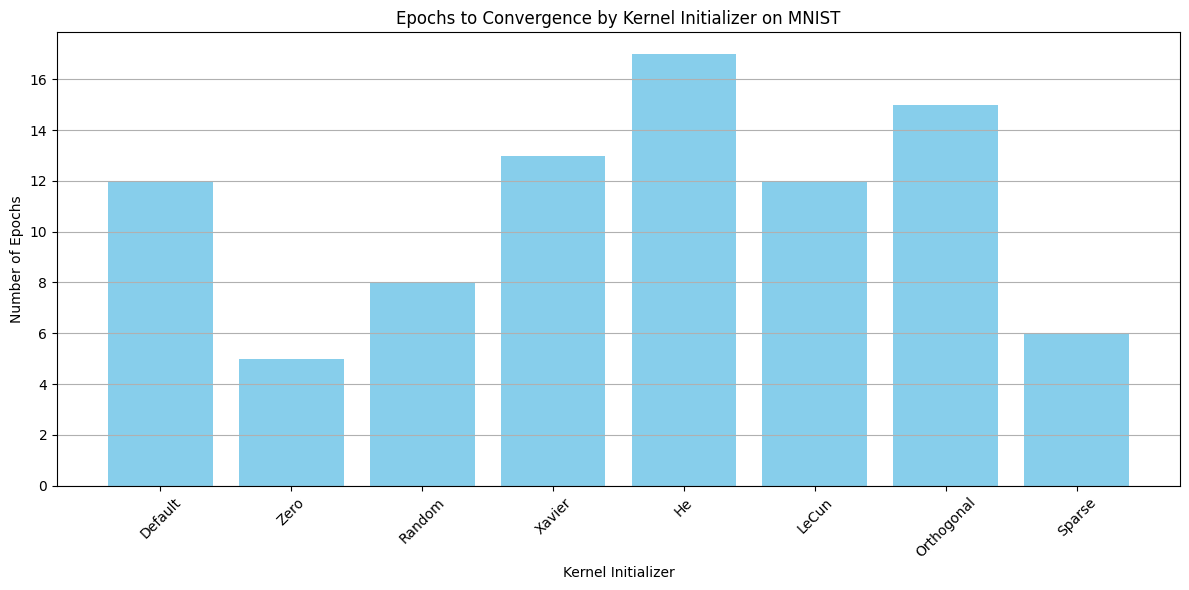

Epochs to convergence for CIFAR-10:
Default: 14 epochs
Zero: 7 epochs
Random: 9 epochs
Xavier: 4 epochs
He: 4 epochs
LeCun: 5 epochs
Orthogonal: 6 epochs
Sparse: 5 epochs


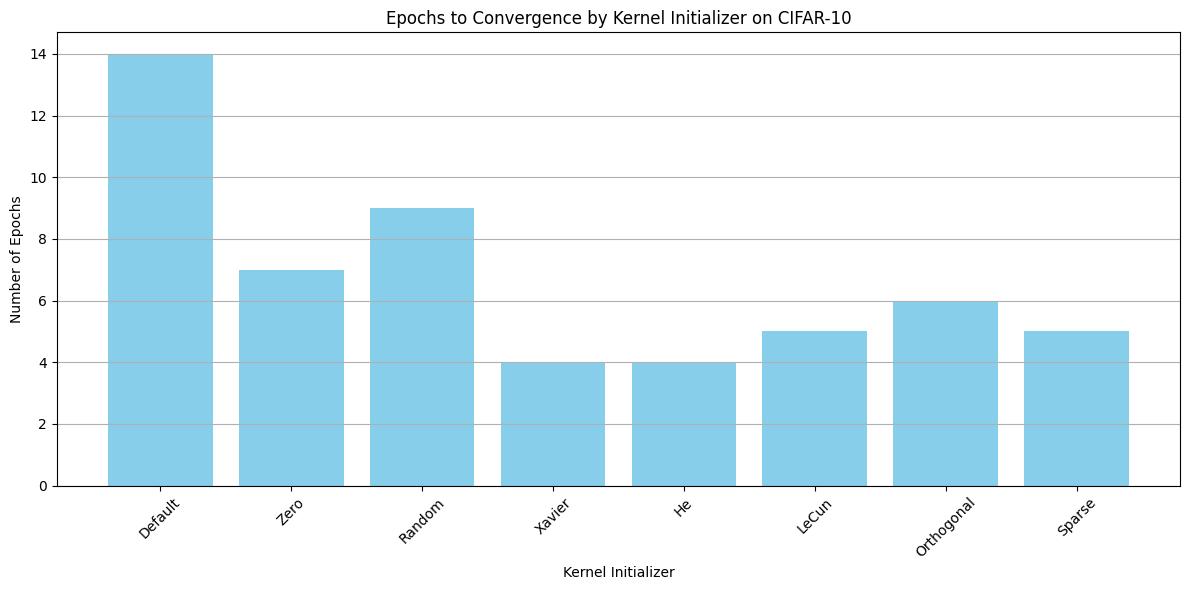

Epochs to convergence for 20 Newsgroups:
Default: 12 epochs
Zero: 20 epochs
Random: 9 epochs
Xavier: 13 epochs
He: 11 epochs
LeCun: 9 epochs
Orthogonal: 12 epochs
Sparse: 8 epochs


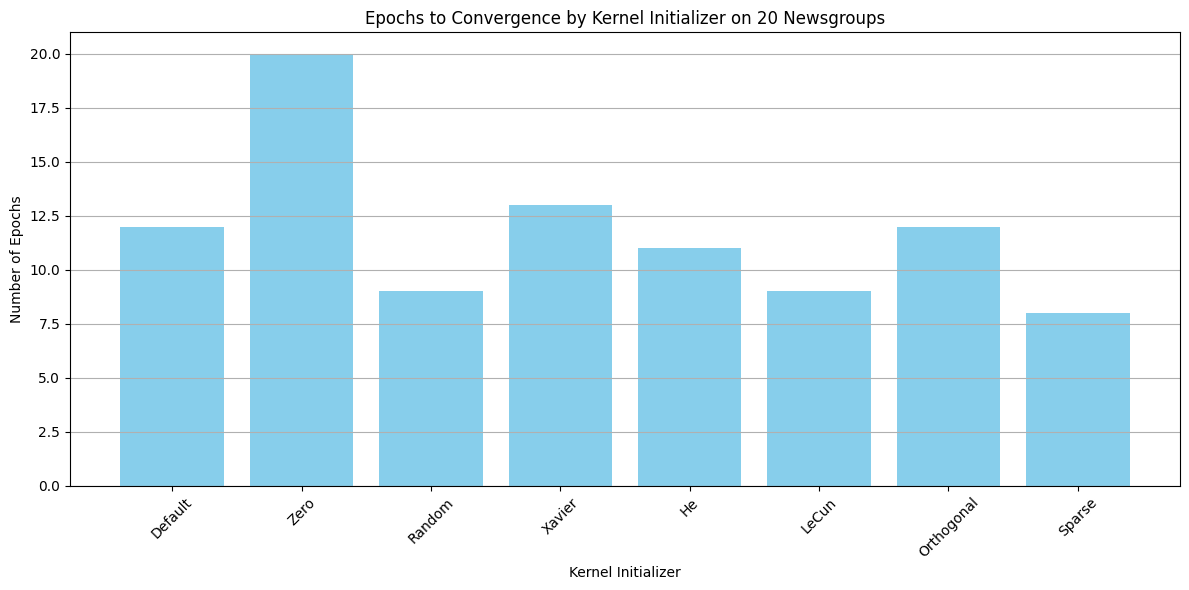

In [7]:
def plot_epochs_to_convergence(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return

    initializers = ['Default'] + list(initializers_dict.keys())
    epochs_to_convergence = [len(results[dataset_name][init]['history']['val_loss']) for init in initializers]

    # Print the data before plotting
    print(f'Epochs to convergence for {dataset_name}:')
    for init, epochs in zip(initializers, epochs_to_convergence):
        print(f'{init}: {epochs} epochs')

    plt.figure(figsize=(12, 6))
    plt.bar(initializers, epochs_to_convergence, color='skyblue')
    plt.title(f'Epochs to Convergence by Kernel Initializer on {dataset_name}')
    plt.xlabel('Kernel Initializer')
    plt.ylabel('Number of Epochs')
    plt.xticks(rotation=45)
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

for dataset_name in datasets.keys():
    plot_epochs_to_convergence(results, dataset_name)

Accuracy data for MNIST:
Default: Test Accuracy = 0.9623000025749207, Validation Accuracy = 0.9623000025749207
Zero: Test Accuracy = 0.11349999904632568, Validation Accuracy = 0.11349999904632568
Random: Test Accuracy = 0.968999981880188, Validation Accuracy = 0.970300018787384
Xavier: Test Accuracy = 0.9592000246047974, Validation Accuracy = 0.9605000019073486
He: Test Accuracy = 0.9620000123977661, Validation Accuracy = 0.9620000123977661
LeCun: Test Accuracy = 0.9650999903678894, Validation Accuracy = 0.9650999903678894
Orthogonal: Test Accuracy = 0.9685999751091003, Validation Accuracy = 0.9690999984741211
Sparse: Test Accuracy = 0.9631999731063843, Validation Accuracy = 0.9663000106811523


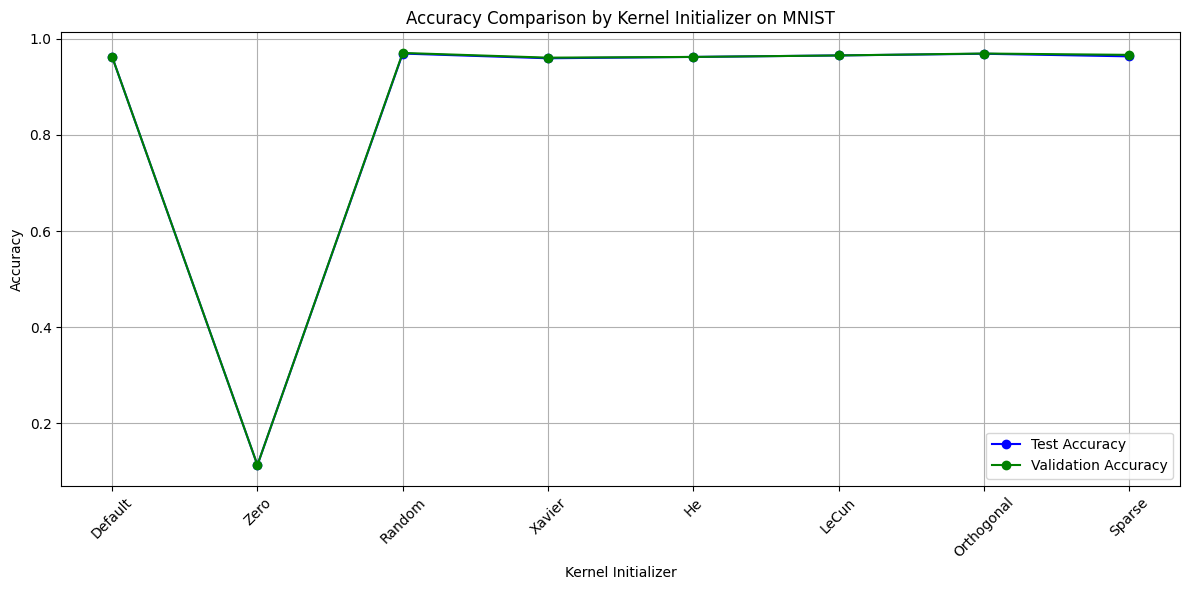

Accuracy data for CIFAR-10:
Default: Test Accuracy = 0.24169999361038208, Validation Accuracy = 0.3043000102043152
Zero: Test Accuracy = 0.10000000149011612, Validation Accuracy = 0.10000000149011612
Random: Test Accuracy = 0.3151000142097473, Validation Accuracy = 0.3151000142097473
Xavier: Test Accuracy = 0.10010000318288803, Validation Accuracy = 0.10010000318288803
He: Test Accuracy = 0.10000000149011612, Validation Accuracy = 0.10000000149011612
LeCun: Test Accuracy = 0.10000000149011612, Validation Accuracy = 0.10010000318288803
Orthogonal: Test Accuracy = 0.10000000149011612, Validation Accuracy = 0.10029999911785126
Sparse: Test Accuracy = 0.18690000474452972, Validation Accuracy = 0.19789999723434448


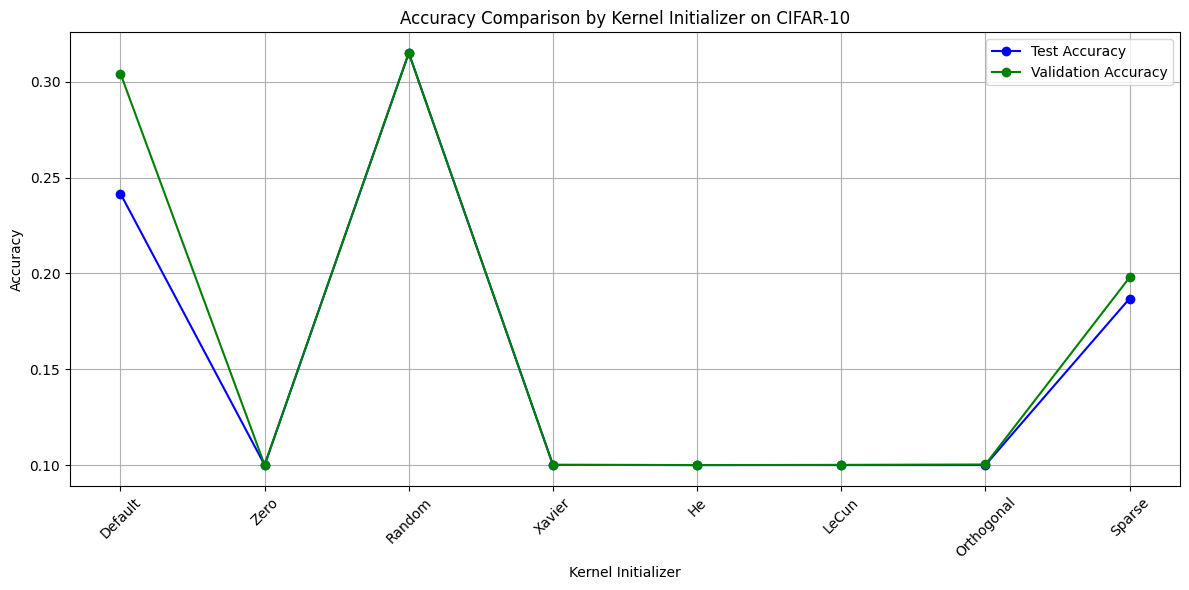

Accuracy data for 20 Newsgroups:
Default: Test Accuracy = 0.8301911950111389, Validation Accuracy = 0.8308550119400024
Zero: Test Accuracy = 0.05297397822141647, Validation Accuracy = 0.05297397822141647
Random: Test Accuracy = 0.7681890726089478, Validation Accuracy = 0.7752256989479065
Xavier: Test Accuracy = 0.8339086771011353, Validation Accuracy = 0.8339086771011353
He: Test Accuracy = 0.8345724940299988, Validation Accuracy = 0.8351035714149475
LeCun: Test Accuracy = 0.8281996846199036, Validation Accuracy = 0.8288635015487671
Orthogonal: Test Accuracy = 0.8369622826576233, Validation Accuracy = 0.8377588987350464
Sparse: Test Accuracy = 0.6806957125663757, Validation Accuracy = 0.6988847851753235


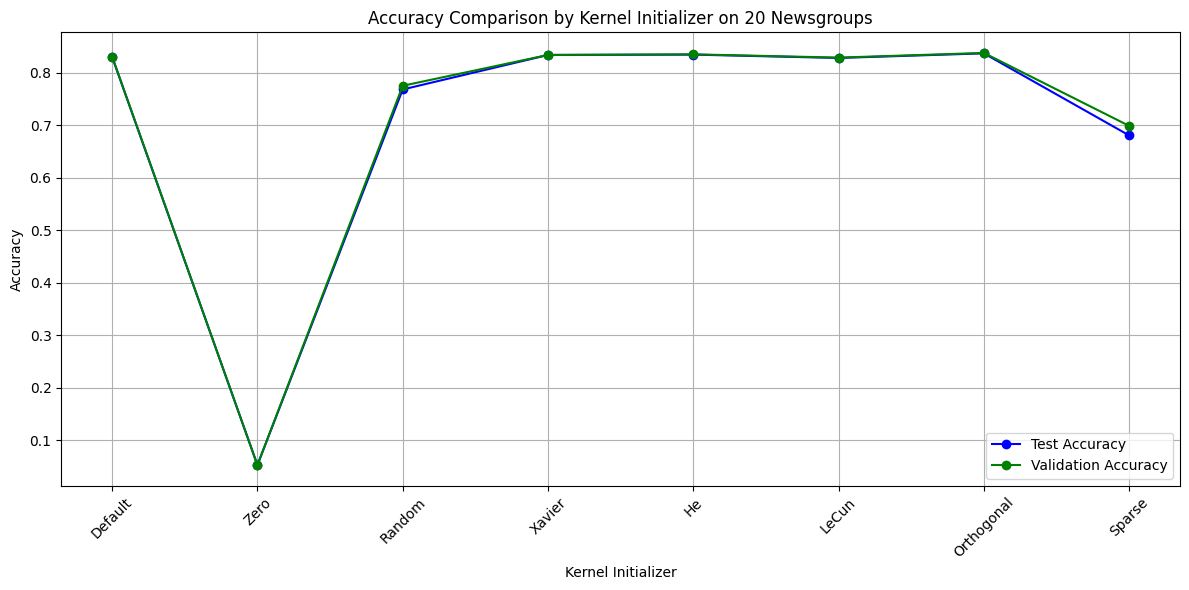

In [8]:
def plot_accuracy_comparison(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return

    initializers = ['Default'] + list(initializers_dict.keys())
    test_accuracies = [results[dataset_name][init]['test_acc'] for init in initializers]
    val_accuracies = [np.max(results[dataset_name][init]['history']['val_accuracy']) for init in initializers]

    # Print the data before plotting
    print(f'Accuracy data for {dataset_name}:')
    for init, test_acc, val_acc in zip(initializers, test_accuracies, val_accuracies):
        print(f'{init}: Test Accuracy = {test_acc}, Validation Accuracy = {val_acc}')

    plt.figure(figsize=(12, 6))
    plt.plot(initializers, test_accuracies, marker='o', label='Test Accuracy', color='blue')
    plt.plot(initializers, val_accuracies, marker='o', label='Validation Accuracy', color='green')
    plt.title(f'Accuracy Comparison by Kernel Initializer on {dataset_name}')
    plt.xlabel('Kernel Initializer')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

for dataset_name in datasets.keys():
    plot_accuracy_comparison(results, dataset_name)

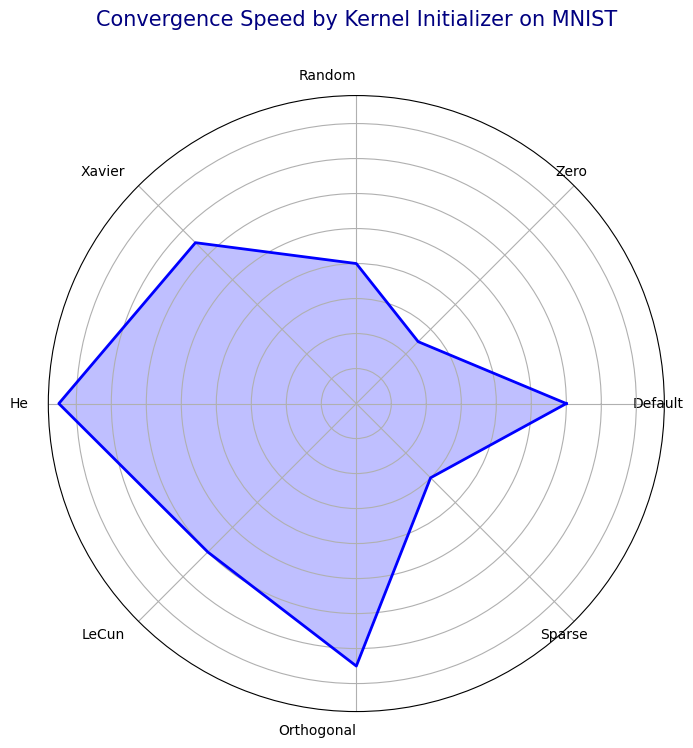

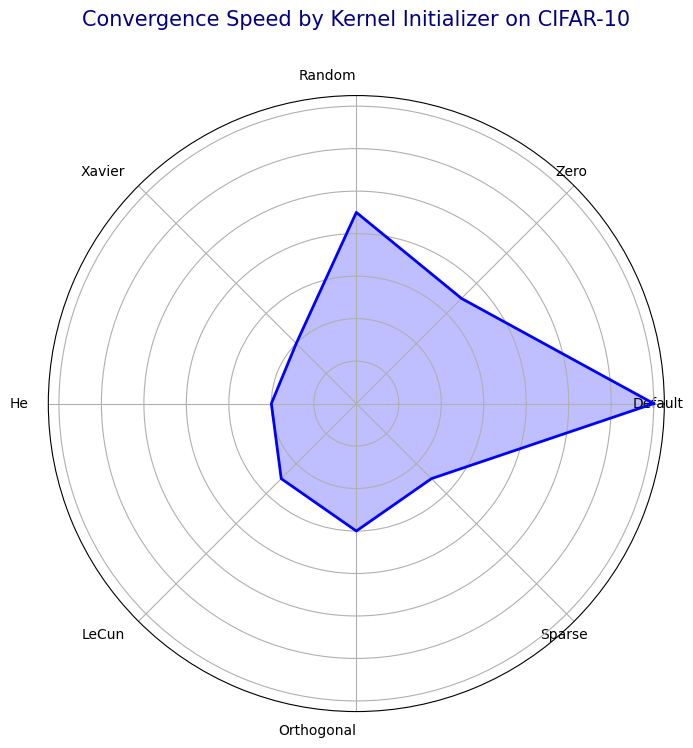

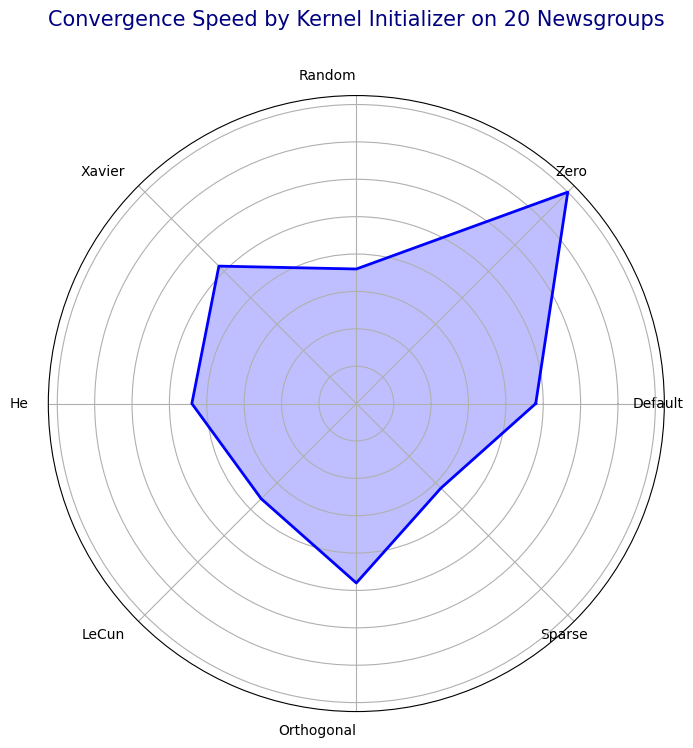

In [9]:
def plot_convergence_speed_radar(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return

    initializers = ['Default'] + list(initializers_dict.keys())
    epochs_to_convergence = [len(results[dataset_name][init]['history']['val_loss']) for init in initializers]

    angles = np.linspace(0, 2 * np.pi, len(initializers), endpoint=False).tolist()
    epochs_to_convergence += epochs_to_convergence[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.fill(angles, epochs_to_convergence, color='blue', alpha=0.25)
    ax.plot(angles, epochs_to_convergence, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(initializers, rotation=45, ha='right')
    ax.set_title(f'Convergence Speed by Kernel Initializer on {dataset_name}', size=15, color='navy', y=1.1)
    plt.show()

for dataset_name in datasets.keys():
    plot_convergence_speed_radar(results, dataset_name)

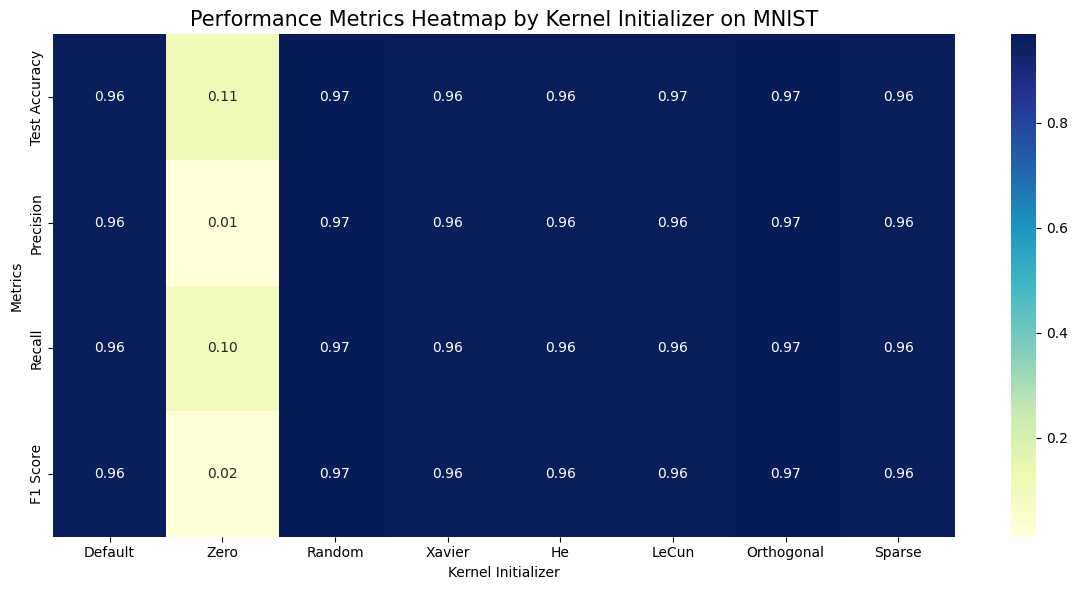

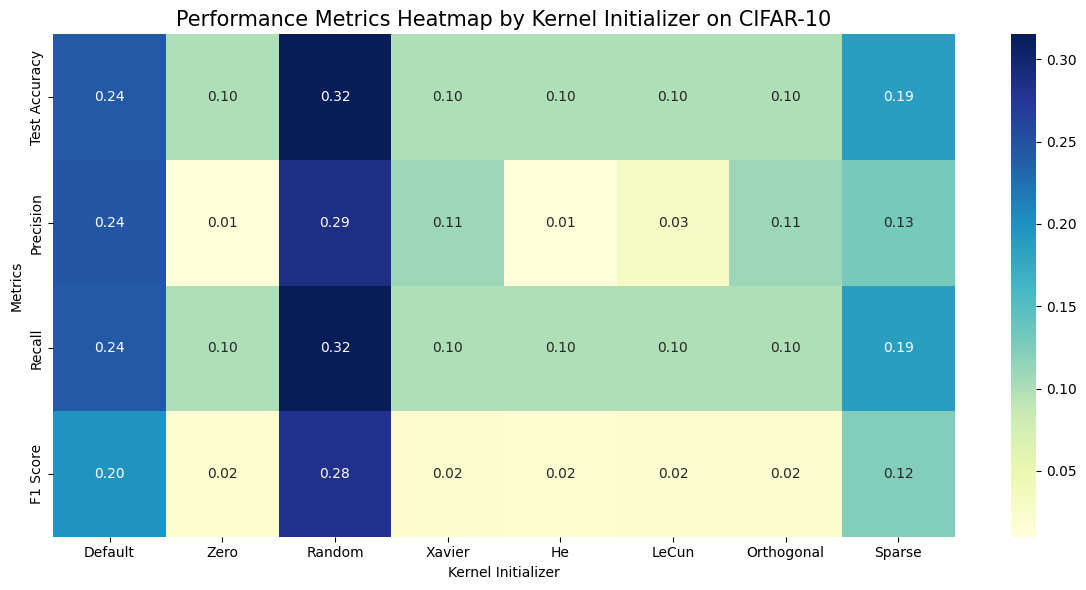

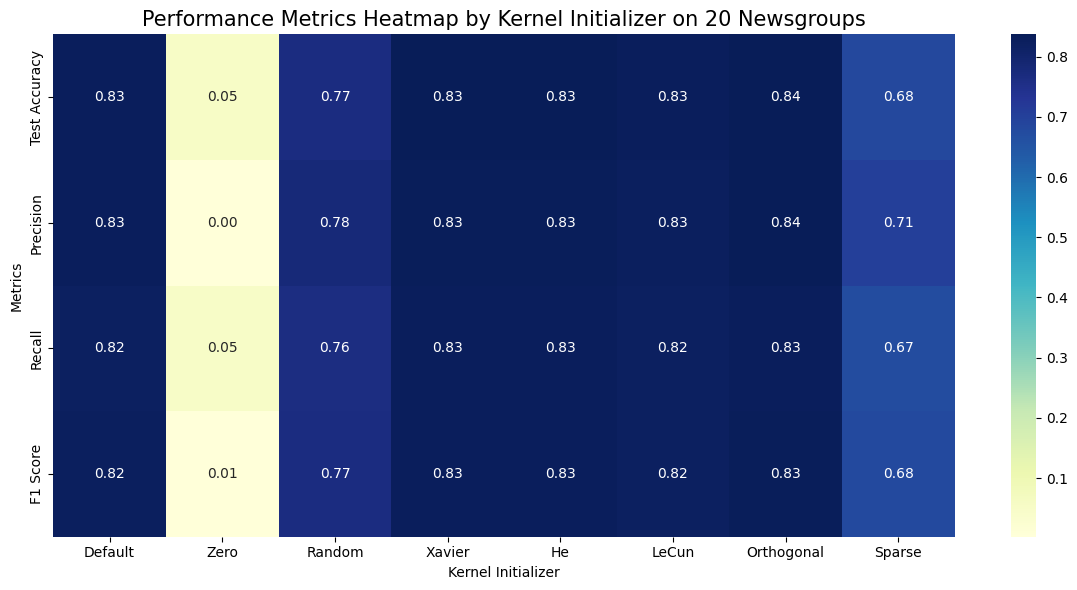

In [10]:
def plot_performance_heatmap(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return

    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['test_acc', 'precision', 'recall', 'f1']
    metrics_labels = ['Test Accuracy', 'Precision', 'Recall', 'F1 Score']

    data = np.array([[results[dataset_name][init][metric] for init in initializers] for metric in metrics])

    plt.figure(figsize=(12, 6))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu", xticklabels=initializers, yticklabels=metrics_labels)
    plt.title(f'Performance Metrics Heatmap by Kernel Initializer on {dataset_name}', size=15)
    plt.xlabel('Kernel Initializer')
    plt.ylabel('Metrics')
    plt.tight_layout()
    plt.show()

for dataset_name in datasets.keys():
    plot_performance_heatmap(results, dataset_name)


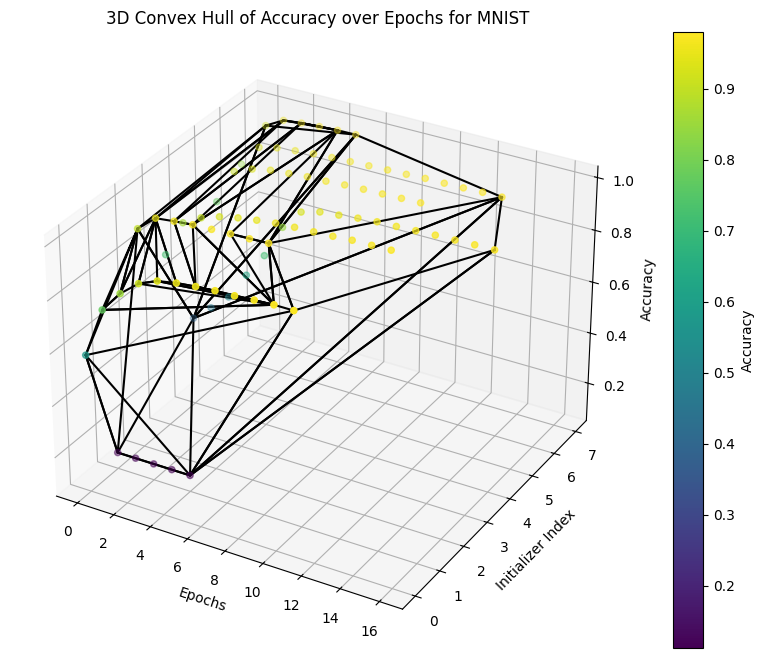

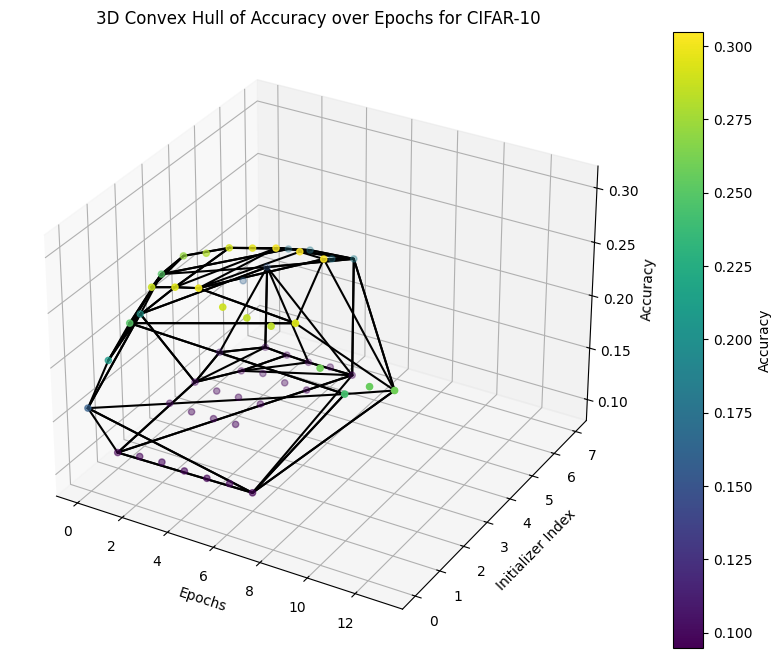

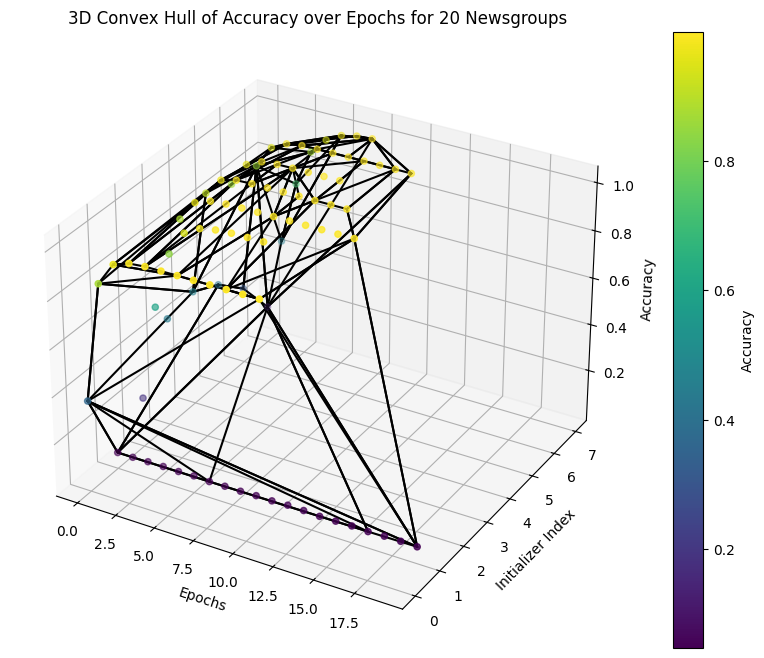

In [11]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
import numpy as np

def plot_3d_convex_hull(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return
    
    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['accuracy']  # We will focus on accuracy over epochs
    
    num_initializers = len(initializers)
    num_epochs = 0
    
    # Collect data
    data = []
    for init in initializers:
        history = results[dataset_name][init].get('history', {})
        if not history:
            print(f"No training history found for initializer '{init}' in {dataset_name}.")
            continue
        if 'accuracy' not in history:
            print(f"Accuracy data not found in history for initializer '{init}' in {dataset_name}.")
            continue
        
        num_epochs = len(history['accuracy'])
        for epoch in range(num_epochs):
            data.append([epoch, initializers.index(init), history['accuracy'][epoch]])
    
    if not data:
        print(f"No valid data to plot for {dataset_name}.")
        return
    
    data = np.array(data)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Compute convex hull
    try:
        hull = ConvexHull(data)
        for simplex in hull.simplices:
            ax.plot(data[simplex, 0], data[simplex, 1], data[simplex, 2], 'k-')
    except Exception as e:
        print(f"Error computing convex hull: {e}")
        return
    
    scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=data[:, 2], cmap='viridis')
    fig.colorbar(scatter, ax=ax, label='Accuracy')
    
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Initializer Index')
    ax.set_zlabel('Accuracy')
    ax.set_title(f'3D Convex Hull of Accuracy over Epochs for {dataset_name}')
    
    plt.show()

for dataset_name in datasets.keys():
    plot_3d_convex_hull(results, dataset_name)


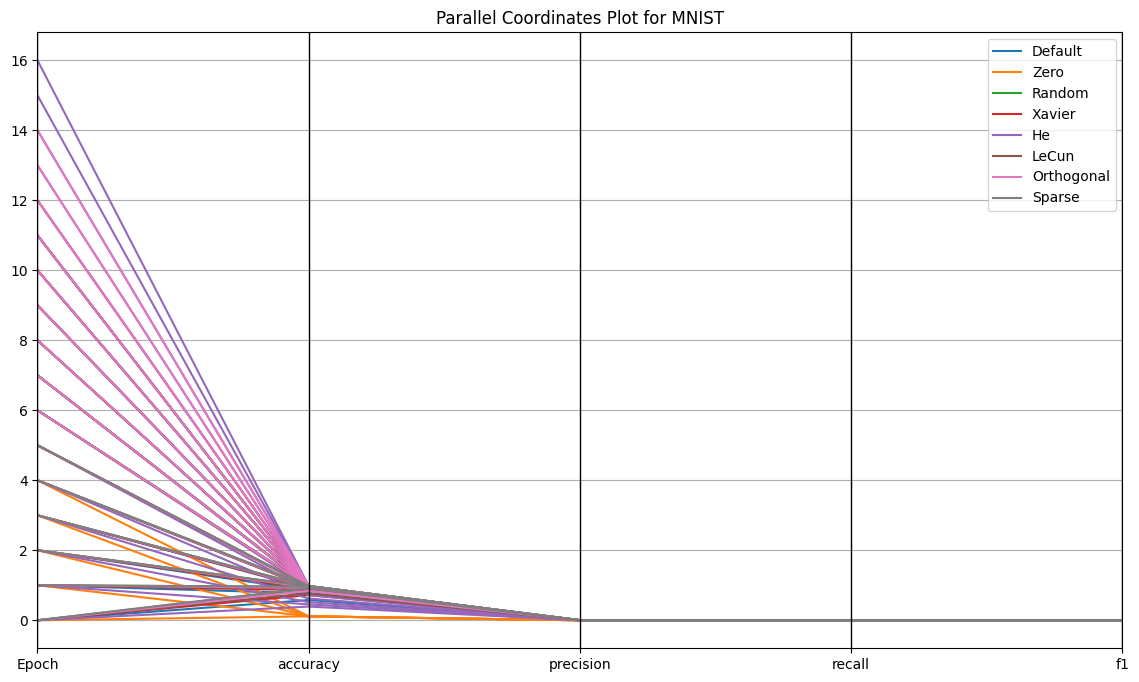

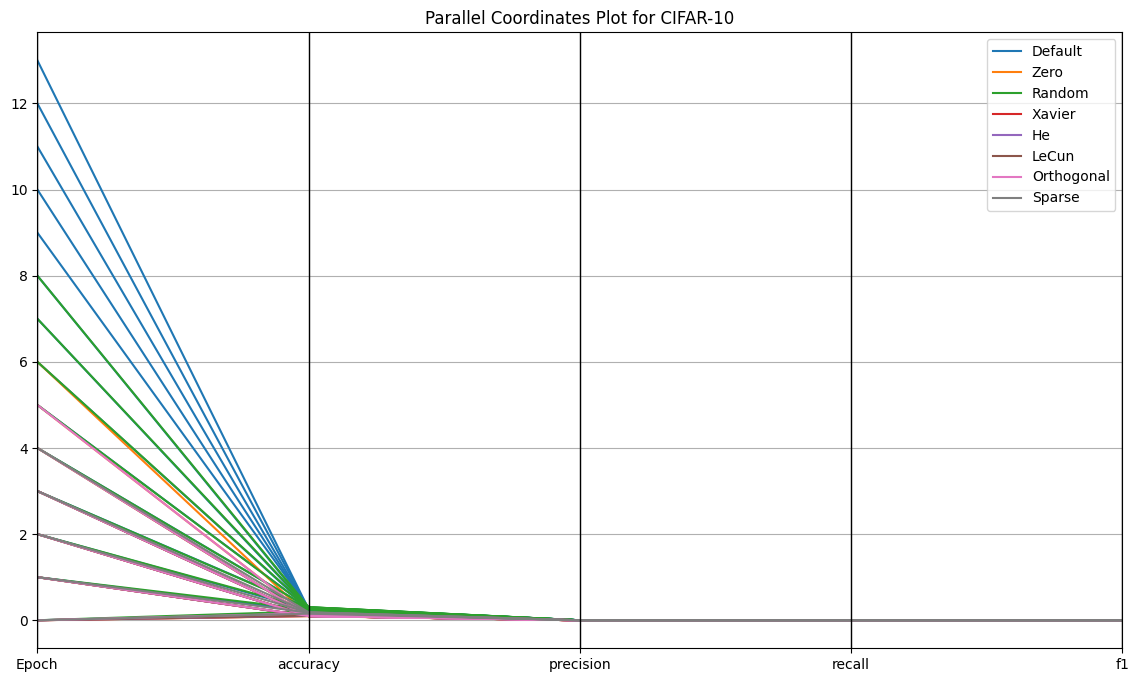

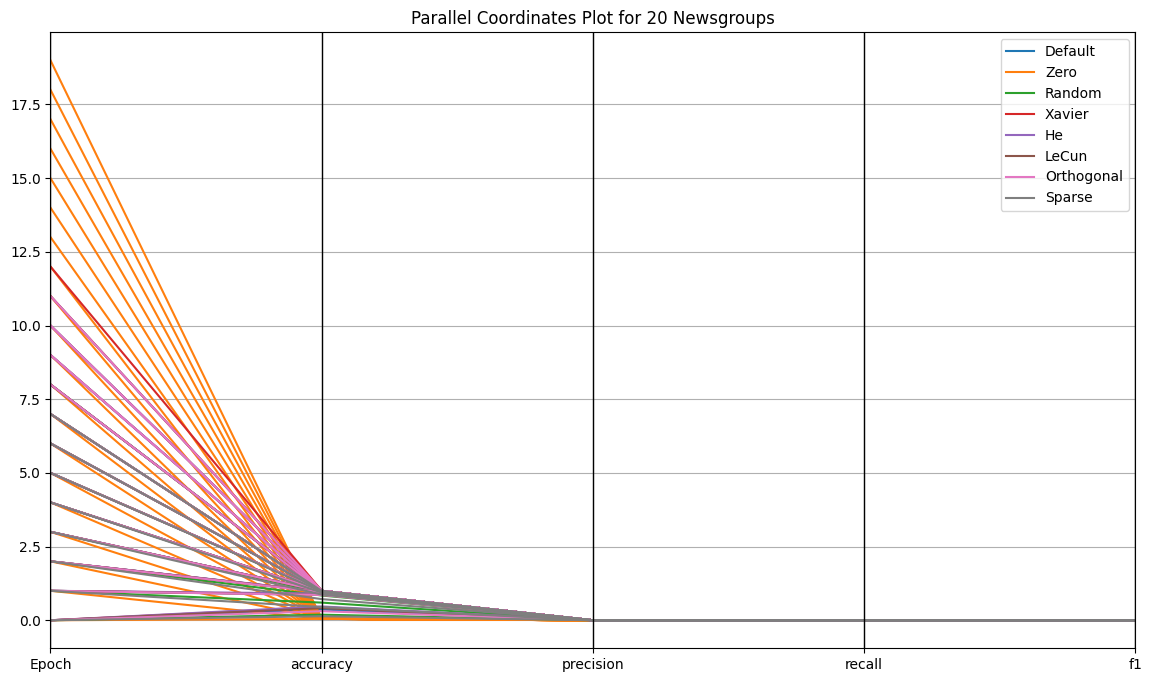

In [12]:
import pandas as pd
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt

def plot_parallel_coordinates(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return
    
    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['accuracy', 'precision', 'recall', 'f1']  # Add more metrics if available

    # Collect data into a DataFrame
    data = []
    for init in initializers:
        history = results[dataset_name][init].get('history', {})
        if not history:
            continue
        
        num_epochs = len(history.get('accuracy', []))
        for epoch in range(num_epochs):
            row = {'Initializer': init, 'Epoch': epoch}
            for metric in metrics:
                row[metric] = history.get(metric, [0])[epoch] if epoch < len(history.get(metric, [])) else 0
            data.append(row)

    if not data:
        print(f"No valid data to plot for {dataset_name}.")
        return
    
    df = pd.DataFrame(data)

    plt.figure(figsize=(14, 8))
    parallel_coordinates(df, 'Initializer', cols=['Epoch'] + metrics, color=plt.get_cmap('tab10').colors)
    plt.title(f'Parallel Coordinates Plot for {dataset_name}')
    plt.show()

for dataset_name in datasets.keys():
    plot_parallel_coordinates(results, dataset_name)


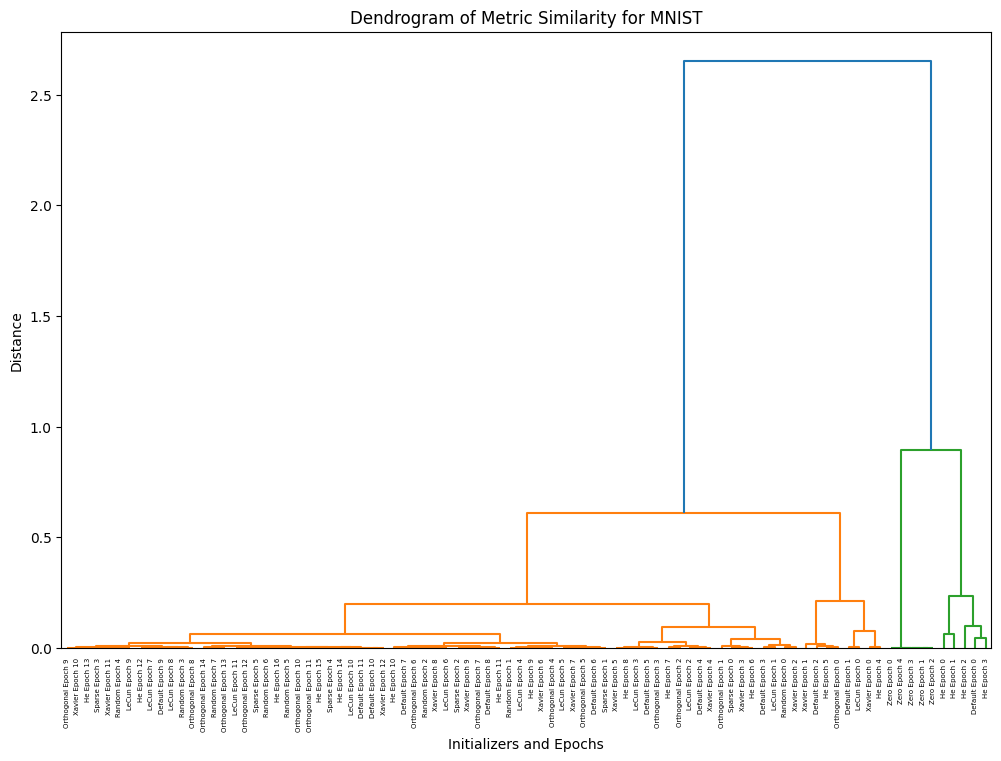

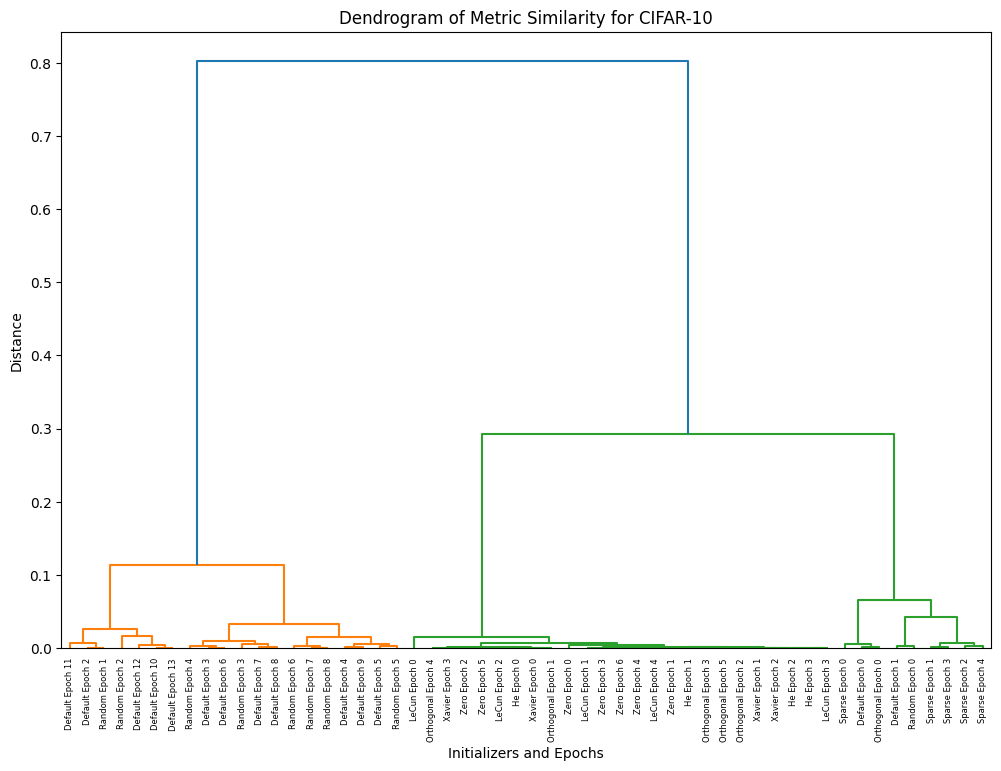

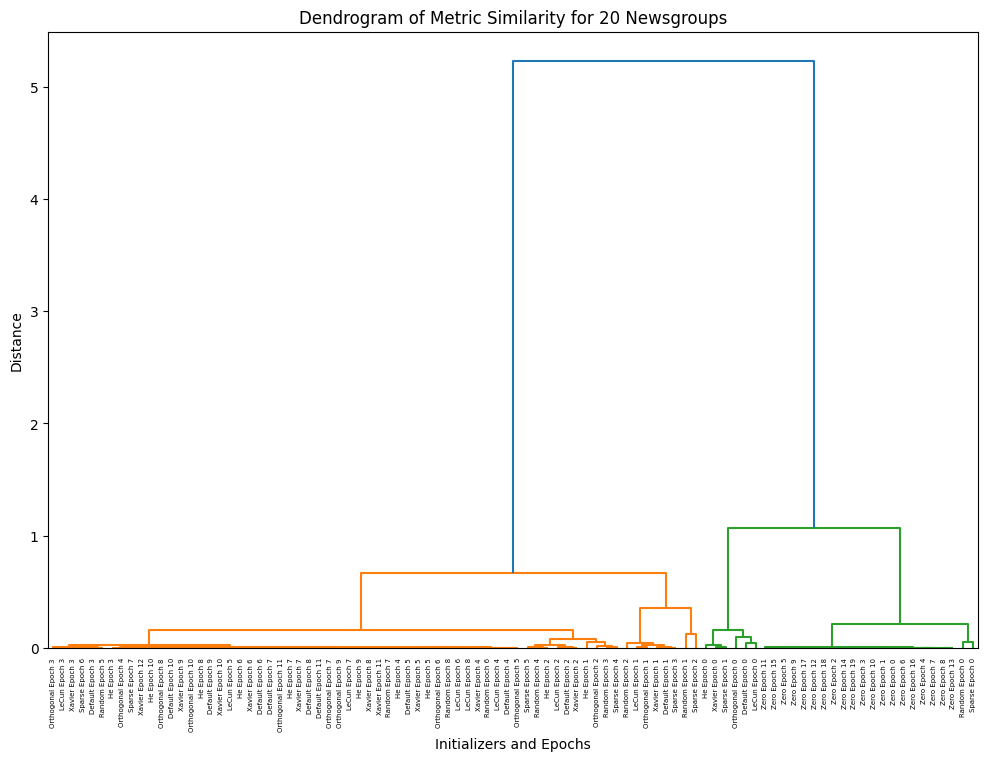

In [13]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import numpy as np

def plot_dendrogram(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return

    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['accuracy', 'precision', 'recall']
    
    all_data = []
    labels = []

    # Collect data for each initializer and epoch
    for init in initializers:
        history = results[dataset_name][init].get('history', {})
        num_epochs = len(history.get('accuracy', []))
        
        # Ensure we handle metrics with possibly different lengths
        max_length = max(len(history.get(metric, [])) for metric in metrics)

        for epoch in range(max_length):
            data_point = []
            for metric in metrics:
                # Use 0 if the metric doesn't have data for this epoch
                data_point.append(history.get(metric, [0])[epoch] if epoch < len(history.get(metric, [])) else 0)
            
            all_data.append(data_point)
            labels.append(f'{init} Epoch {epoch}')

    all_data = np.array(all_data)
    distance_matrix = sch.distance.pdist(all_data, metric='euclidean')
    linkage_matrix = sch.linkage(distance_matrix, method='ward')

    plt.figure(figsize=(12, 8))
    sch.dendrogram(linkage_matrix, labels=labels, orientation='top')
    plt.title(f'Dendrogram of Metric Similarity for {dataset_name}')
    plt.xlabel('Initializers and Epochs')
    plt.ylabel('Distance')
    plt.xticks(rotation=90)
    plt.show()

for dataset_name in datasets.keys():
    plot_dendrogram(results, dataset_name)


In [14]:
import plotly.express as px
import pandas as pd

def plot_parallel_coordinates(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return
    
    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['test_acc', 'precision', 'recall', 'f1']
    data = []

    for init in initializers:
        row = {'Initializer': init}
        for metric in metrics:
            row[metric] = results[dataset_name][init][metric]
        data.append(row)
    
    df = pd.DataFrame(data)
    
    fig = px.parallel_coordinates(df, dimensions=metrics, color='f1', 
                                  color_continuous_scale=px.colors.sequential.Viridis,
                                  labels={metric: metric.replace('_', ' ').capitalize() for metric in metrics})
    fig.update_layout(title=f'Parallel Coordinates Plot for {dataset_name}')
    fig.show()

for dataset_name in datasets.keys():
    plot_parallel_coordinates(results, dataset_name)


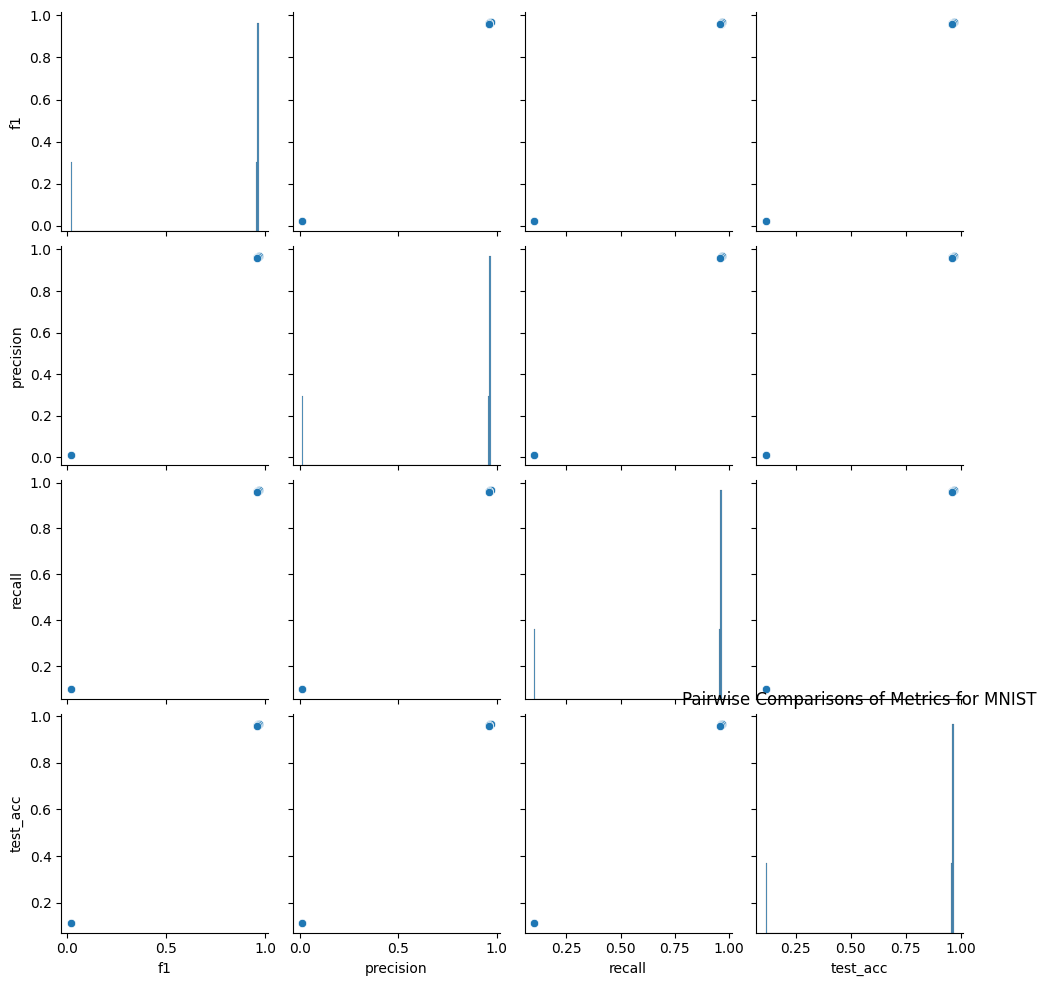

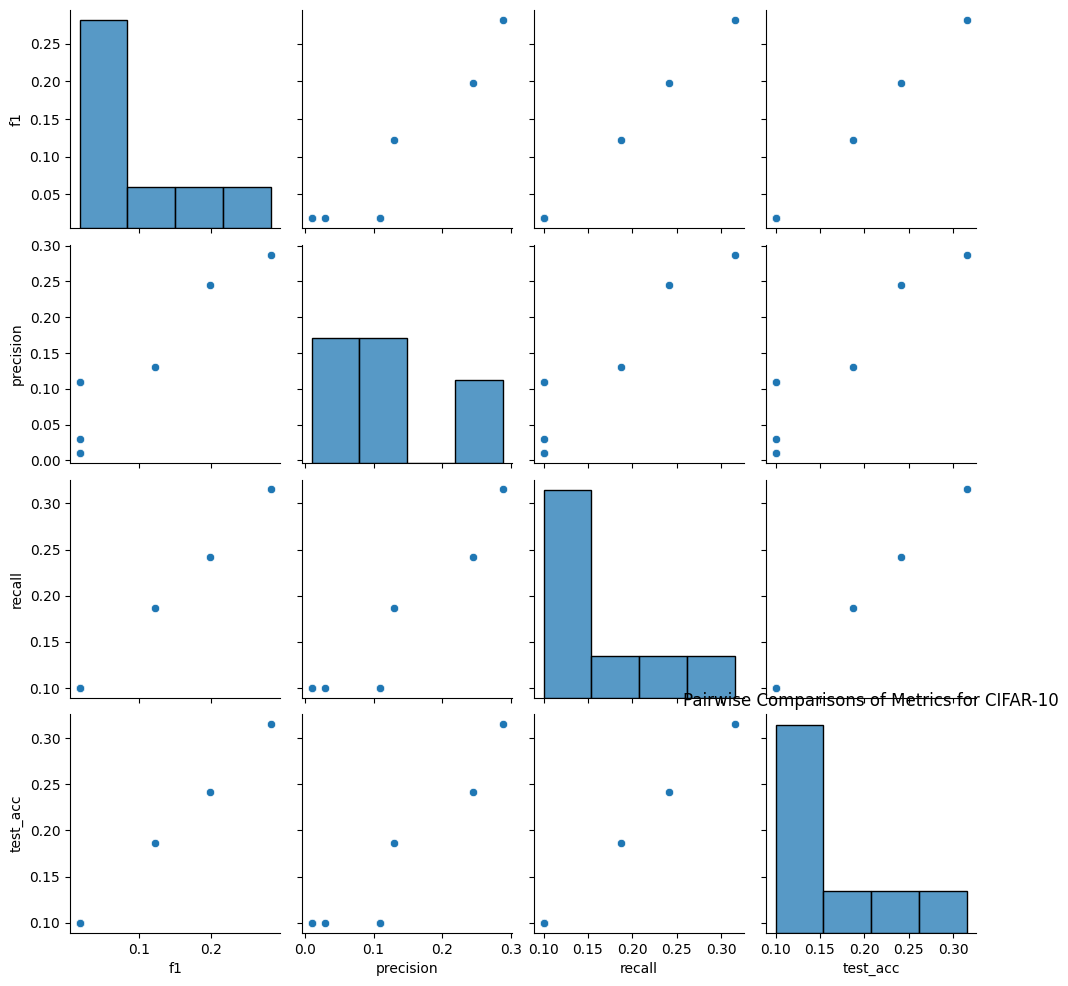

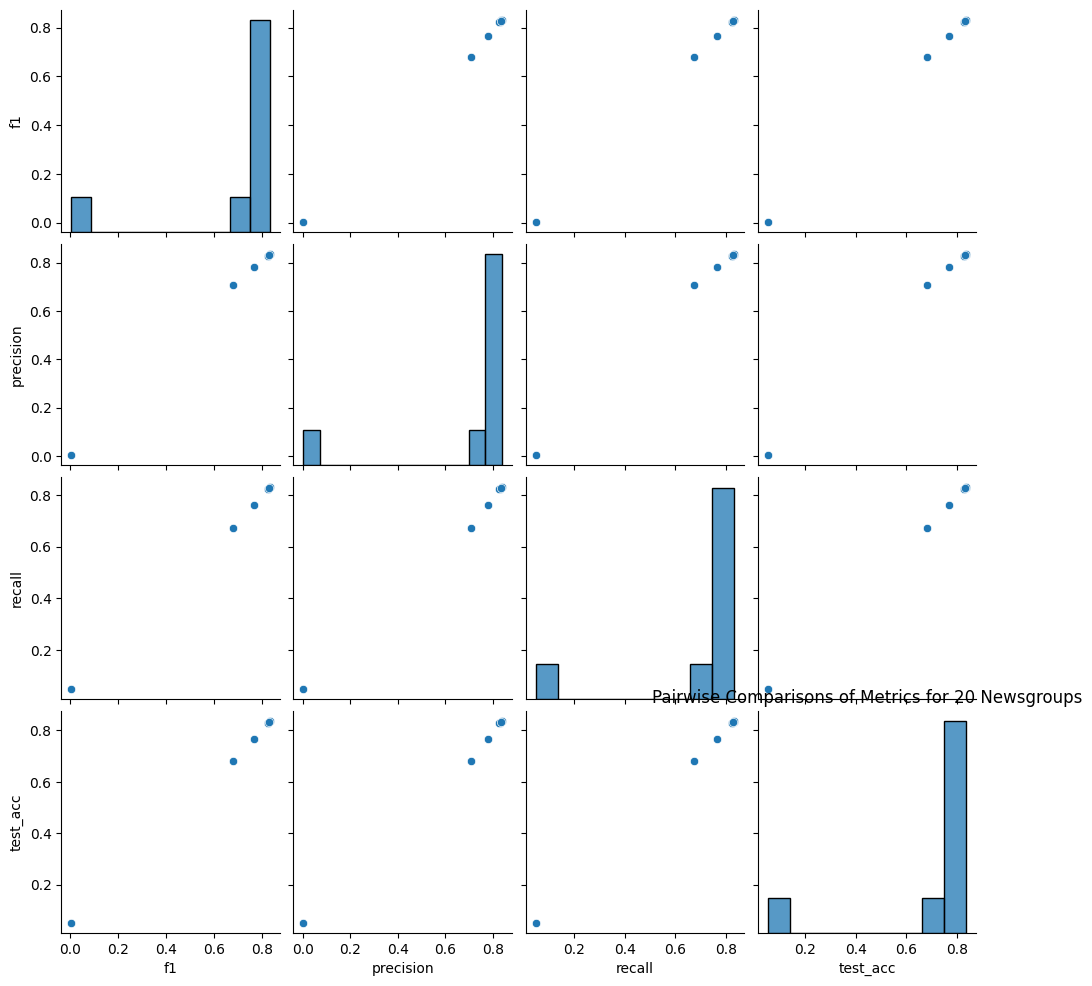

In [15]:
import pandas as pd
import seaborn as sns

def plot_pairwise_comparisons(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return

    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['test_acc', 'precision', 'recall', 'f1']
    
    # Prepare the data for pairwise plotting
    data = []
    for init in initializers:
        for metric in metrics:
            data.append([init, metric, results[dataset_name][init][metric]])
    
    df = pd.DataFrame(data, columns=['Initializer', 'Metric', 'Value'])

    # Pivot the dataframe to have metrics as columns
    df_pivot = df.pivot_table(index='Initializer', columns='Metric', values='Value')
    
    # Plot pairwise comparisons
    sns.pairplot(df_pivot)
    plt.title(f'Pairwise Comparisons of Metrics for {dataset_name}')
    plt.show()

for dataset_name in datasets.keys():
    plot_pairwise_comparisons(results, dataset_name)


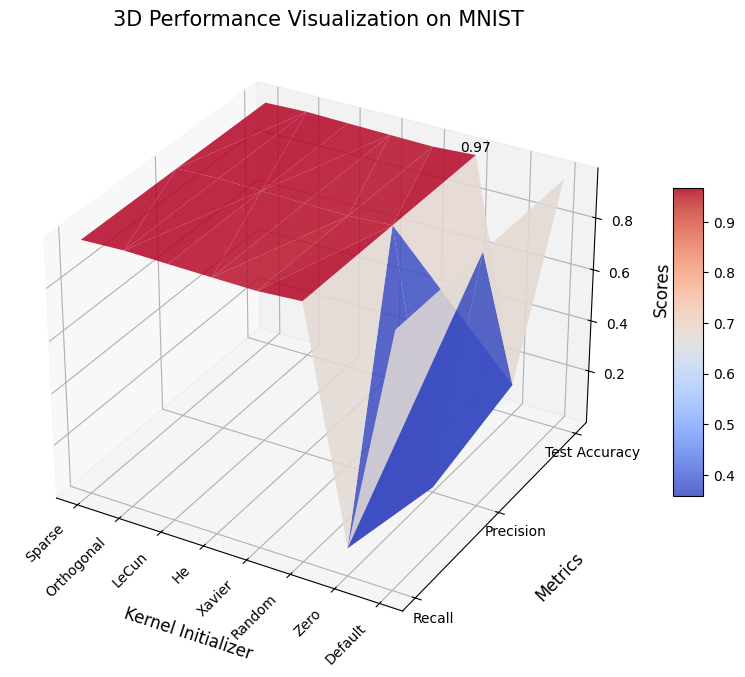

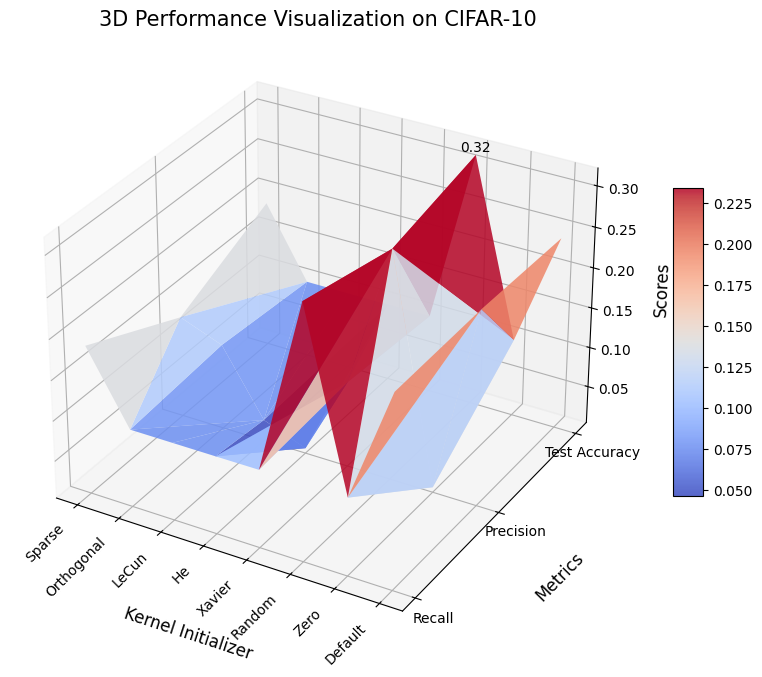

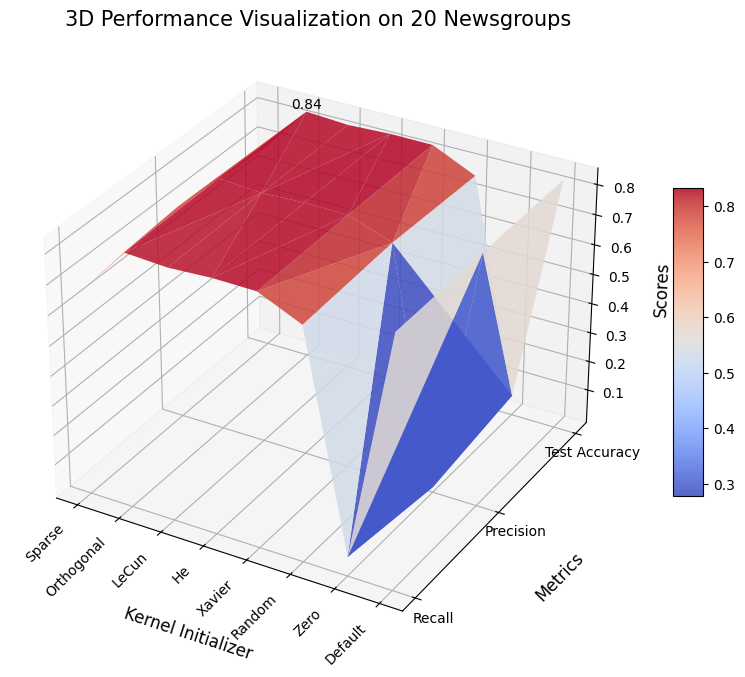

In [16]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt

def plot_3d_performance_enhanced_clear_labels(results, dataset_name):
    if dataset_name not in results:
        print(f"No results found for {dataset_name}. Skipping...")
        return
    
    initializers = ['Default'] + list(initializers_dict.keys())
    metrics = ['test_acc', 'precision', 'recall']
    metric_labels = ['Test Accuracy', 'Precision', 'Recall']
    
    # Collect the data
    data = np.array([[results[dataset_name][init][metric] for init in initializers] for metric in metrics])
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Create meshgrid for plotting
    X, Y = np.meshgrid(range(len(initializers)), range(len(metrics)))
    X, Y = X.flatten(), Y.flatten()
    Z = data.flatten()
    
    # Plot the surface with color mapping based on Z-values
    surf = ax.plot_trisurf(X, Y, Z, cmap=cm.coolwarm, linewidth=0.2, alpha=0.85)
    
    # Add a color bar to indicate the scale of the Z-values
    fig.colorbar(surf, shrink=0.5, aspect=10)

    # Annotate the highest point for better clarity
    max_z_idx = np.argmax(Z)
    ax.text(X[max_z_idx], Y[max_z_idx], Z[max_z_idx], 
            f'{Z[max_z_idx]:.2f}', color='black', fontsize=10, 
            ha='center', va='bottom')

    # Adjust the positions of the axis labels
    ax.set_xlabel('Kernel Initializer', fontsize=12, labelpad=20)
    ax.set_ylabel('Metrics', fontsize=12, labelpad=20)
    ax.set_zlabel('Scores', fontsize=12, labelpad=10)
    ax.set_title(f'3D Performance Visualization on {dataset_name}', fontsize=15)
    
    # Set ticks with a little extra padding
    ax.set_xticks(range(len(initializers)))
    ax.set_xticklabels(initializers, rotation=45, ha='right', fontsize=10, va='center_baseline')

    ax.set_yticks(range(len(metrics)))
    ax.set_yticklabels(metric_labels, fontsize=10, va='center_baseline')
    
    # Interactive features
    ax.view_init(elev=30, azim=120)
    plt.show()

for dataset_name in datasets.keys():
    plot_3d_performance_enhanced_clear_labels(results, dataset_name)
